* Set up paths for Fast R-CNN.

In [1]:
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

# Add caffe to PYTHONPATH
add_path('caffe-fast-rcnn/python')

# Add lib to PYTHONPATH
add_path('lib')

* Import libraries and setup matplotlib

In [2]:
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Create a list of classes and a map of trained nets

In [3]:
CLASSES = ('__background__', 'car', 'truck', 'pedestrian', 'trafficLight', 'biker')

* Enable RPN (Region Prediction Net) and set cpu or gpu mode

In [4]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
cpu_mode = True
if cpu_mode:
    caffe.set_mode_cpu()
else:
    caffe.set_mode_gpu()
    caffe.set_device(0)
    cfg.GPU_ID = 0

# Set models directory
cfg.MODELS_DIR = "models/"

* Load the trained net into Caffe

In [5]:
prototxt = os.path.join(cfg.MODELS_DIR, 'mynet', 'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models', 'mynet_faster_rcnn_final.caffemodel')

if not os.path.isfile(caffemodel):
    raise IOError('%s not found' % caffemodel)

if not os.path.isfile(prototxt):
    raise IOError('%s not found' % (prototxt))
    
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print('Loaded network %s' % caffemodel)

Loaded network /home/marcus/Programming/ComputerVision/py-faster-rcnn/data/faster_rcnn_models/mynet_faster_rcnn_final.caffemodel


In [6]:
# Warmup on a dummy image
im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
for i in range(2):
    _, _= im_detect(net, im)

* Load a demo image to test object detection

In [7]:
image_name = os.path.join(cfg.DATA_DIR, 'MyData', 'crowdai_img.jpg')

print('Detecting objects in image %s' % image_name)

# Load image
im = cv2.imread(image_name)

Detecting objects in image /home/marcus/Programming/ComputerVision/py-faster-rcnn/data/MyData/crowdai_img.jpg


* Perform object detection (im_detect)

In [8]:
# Detect all object classes and regress object bounds
timer = Timer()
timer.tic()
scores, boxes = im_detect(net, im)
timer.toc()
print(('Detection took {:.3f}s for {:d} object proposals').format(timer.total_time, boxes.shape[0]))

Detection took 2.237s for 300 object proposals


In [9]:
### Draw detected bounding boxes ###
def vis_detections(im, class_name, dets, ax, thresh=0.5):
    inds = np.where(dets[:, -1] >= thresh)[0] # inds = the list of the indices of
    if len(inds) == 0:                        # objects whose score are above tresh
        return
    
    # For every object we detected
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        # Draw bounding box
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        
        # Draw class name and score
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
        


* Plot the detection results

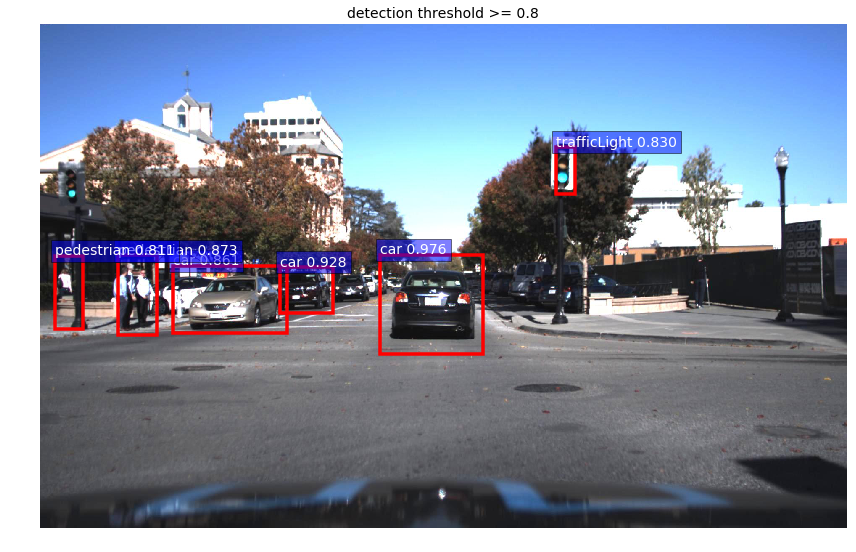

In [10]:
# Convert image from BGR to RGB
imrgb = im[:, :, (2, 1, 0)]
    
# Plot image in figure
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(imrgb, aspect='equal')

# Visualize detections for each class
CONF_THRESH = 0.8
NMS_THRESH = 0.3
ax.set_title(('detection threshold >= {:.1f}').format(CONF_THRESH), fontsize=14)
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)] # Grabs all the (300) rectangles for this class
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis]) # Create a list dets[n] = [x0, y0, x1, y1, score]
                     ).astype(np.float32)                   # Basically, append the score to the rectangle coordinates
    keep = nms(dets, NMS_THRESH) # Non-maximum supression
    dets = dets[keep, :] # Remove non-maxima rectangles from dets
    vis_detections(im, cls, dets, ax, thresh=CONF_THRESH) # Visualize detections

# Draw and show figure
plt.axis('off')
plt.tight_layout()
plt.draw()
plt.show()

In [11]:
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1 # because we skipped background
    print(cls, scores[:, cls_ind].max())

car 0.976475
truck 0.348975
pedestrian 0.873353
trafficLight 0.830396
biker 0.0826708
